In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [3]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

1


In [7]:
train = pd.read_csv("train_QSVM.csv")
test = pd.read_csv("test_QSVM.csv")

X_train = train.drop(columns=["category"])
y_train = train["category"]

X_test = test.drop(columns=["category"])
y_test = test["category"]

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Eliminamos la primera columna, generada al pasar el conjunto de datos a formato csv.
train=train.drop(columns='Unnamed: 0')
test=test.drop(columns='Unnamed: 0')

train['proto'] = train['proto'].map({'TCP': 0, 'UDP': 1})
test['proto'] = test['proto'].map({'TCP': 0, 'UDP': 1})

In [6]:
porcentaje_mantener = 0.001

train_reducido_udp = train[train['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
train_reducido_tcp = train[train['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

train = pd.concat([train_reducido_udp, train_reducido_tcp])


test_reducido_udp = test[test['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
test_reducido_tcp = test[test['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

test = pd.concat([test_reducido_udp, test_reducido_tcp])

In [7]:
feature_cols = [
    'dstport.std', 'tcp.flags.ack', 'tcp.flags.reset', 'tcp.flags.syn',
    'int.max', 'count', 'ip.ttl.max', 'tcp.seq_raw.std', 'tcp.seq_raw.mean',
    'tcp.ack_raw.min', 'tcp.ack_raw.max', 'tcp.window_size_value.min',
    'tcp.window_size_value.mean', 'payload.min', 'payload.mean'
]

label_col = 'category'

X_train = train[feature_cols]
y_train = train[label_col]

X_test = test[feature_cols]
y_test = test[label_col]

In [8]:
Scaler = StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)    

In [9]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_scaled, y_train)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test_scaled, y_test))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(3.1)}
Best Cross Validation Score: 0.6210201793721973
Test Score: 0.6625


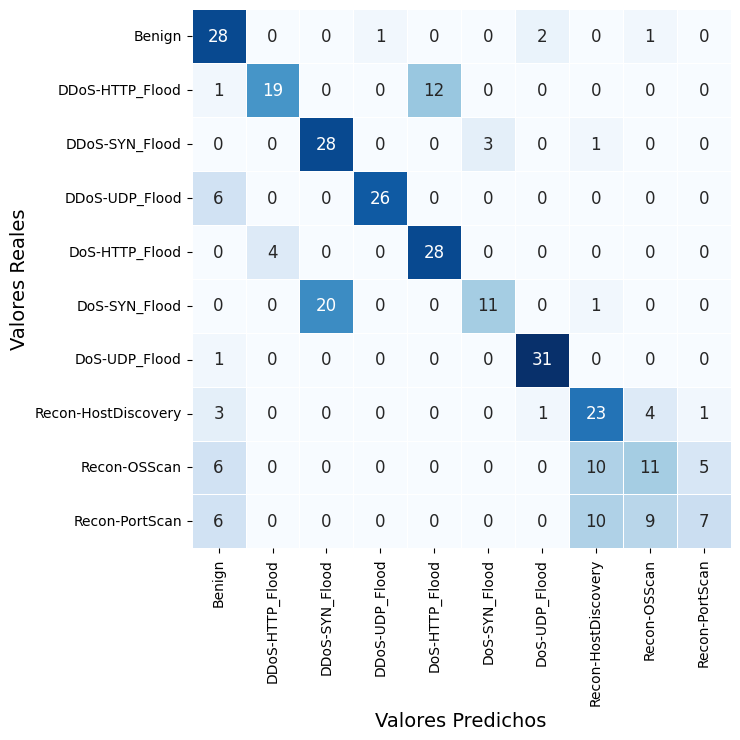

In [11]:
from sklearn import metrics
y_pred = grid.best_estimator_.predict(X_test_scaled)
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

# Plot
sns.heatmap(
    normalized_matrix, 
    annot=True, 
    fmt='0.0f', 
    linewidth=0.5,
    annot_kws={"size": 12}, 
    xticklabels=class_names,
    yticklabels=class_names, 
    square=True, 
    cmap='Blues', 
    cbar=False
)

fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.ylabel('Valores Reales', fontsize=14)
plt.xlabel('Valores Predichos', fontsize=14)

# Guardar como PDF (¡hazlo antes del plt.show!)
plt.savefig('CM_SVM.pdf', format='pdf', bbox_inches='tight')

plt.show()


/home/iraizozj/entorno/entorno/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


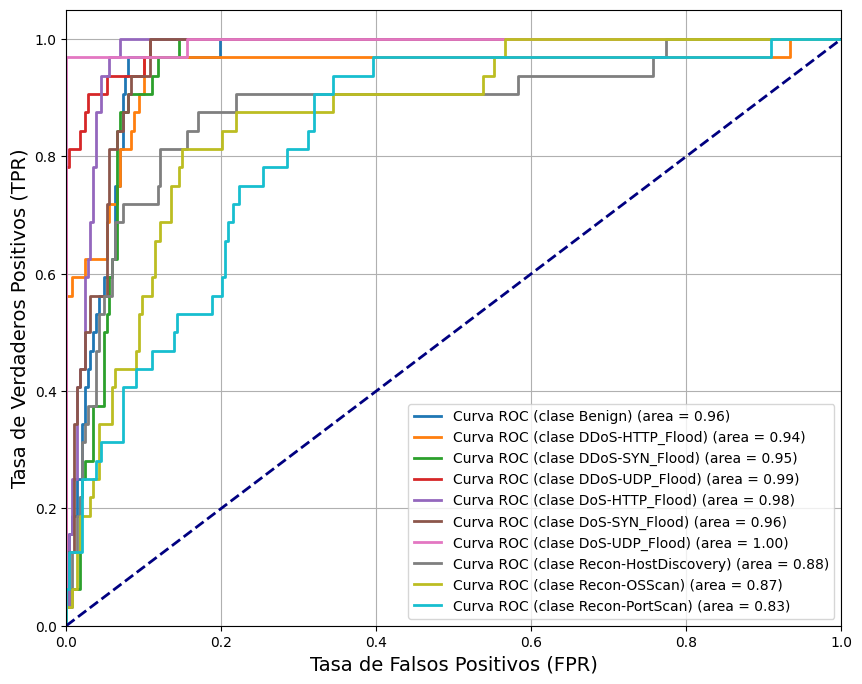

In [14]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = grid.best_estimator_.decision_function(X_test)

# Binarizar las etiquetas
from sklearn.preprocessing import label_binarize
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], lw=2,
             label=f'Curva ROC (clase {class_label}) (area = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC_SVM.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", #ibm_cloud
                               token='3aa94245772e1f158c23f72db59e301c40162b1807e98fb757bc1dc9e70f9f425f48bcfd6fe16305d02d332b18eae862e3ccdb625e5d6955141bbc6ad8aa26fa')

QiskitRuntimeService.save_account(channel='ibm_quantum',
                                  token='3aa94245772e1f158c23f72db59e301c40162b1807e98fb757bc1dc9e70f9f425f48bcfd6fe16305d02d332b18eae862e3ccdb625e5d6955141bbc6ad8aa26fa')

In [5]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=3, reps=1)

feature_map.decompose().decompose().draw(output='mpl')
import matplotlib.pyplot as plt

fig = feature_map.decompose().decompose().draw(output='mpl')
fig.savefig('feature_map_representation.pdf', bbox_inches='tight')
plt.close(fig)

# Save the feature map representation
#plt.savefig('plots/feature_map_representation.png')

In [15]:
from qiskit_ibm_runtime import Session, SamplerV2, EstimatorV2
#from qiskit.providers.fake_provider import Fake127QPulseV1
#from qiskit_ibm_runtime.fake_provider import FakeBrisbane 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, QasmSimulator
#from qiskit_aer.primitives import SamplerV2

from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel, FidelityStatevectorKernel
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap

#service = QiskitRuntimeService()
#back = service.backend(name='ibm_brisbane')

num_qubits = X_train.shape[1]
backend = AerSimulator(method='statevector', device='GPU')#, noise_model=back)
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=0, target=backend.target)

sampler = SamplerV2(mode=session)
fidelity = ComputeUncompute(sampler=sampler, pass_manager=pass_manager)

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
qk = FidelityStatevectorKernel(feature_map=feature_map)

In [16]:
# Verificar si se seleccionó GPU
print(f"Backend device: {backend.options.device}")

Backend device: GPU


In [10]:
from qiskit_machine_learning.algorithms import QSVC
import time

qsvc = QSVC(quantum_kernel=qk, C=1, random_state=42)

start = time.time()
qsvc.fit(X_train, y_train)
stop = time.time()

train_time = stop - start

start = time.time()
y_pred = qsvc.predict(X_test)
stop = time.time()

test_time = stop - start

print(f"Training Time: {train_time}")
print(f"Testing Time: {test_time}")
print(f"Total Time: {train_time + test_time}")
print(f"QSVC training score: {qsvc.score(X_train, y_train)}")
print('Precision en test: ', accuracy_score(y_test, y_pred))

Training Time: 35388.535014390945
Testing Time: 19194.76859807968
Total Time: 54583.30361247063
QSVC training score: 0.7470956210902592
Precision en test:  0.65625


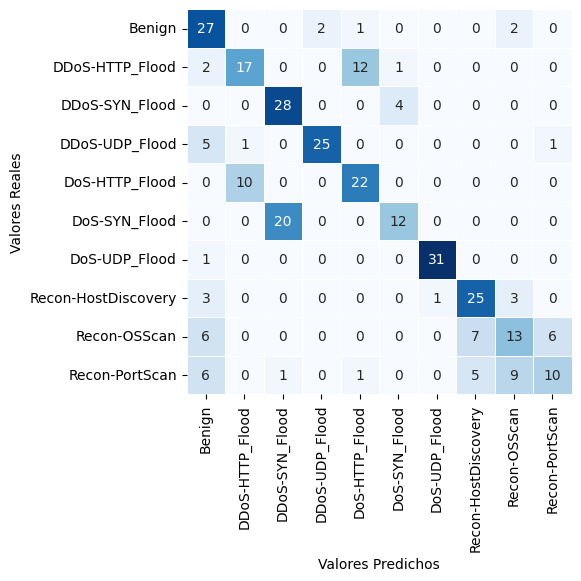

In [11]:
cm1 = confusion_matrix(y_test, y_pred)
normalized_matrix = cm1 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

## Method 2: Precomputed Kernel

In [12]:
Quantum_scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
X_train_Qscaled = Quantum_scaler.fit_transform(X_train)
X_test_Qscaled = Quantum_scaler.transform(X_test)

In [17]:
import time

start = time.time()
matrix_train = qk.evaluate(x_vec=X_train)
stop = time.time()

train_time = stop - start

In [18]:
start = time.time()
matrix_test = qk.evaluate(x_vec=X_test, y_vec=X_train)
stop = time.time()

test_time = stop - start

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV

SVM = SVC(kernel='precomputed', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(matrix_train, y_train)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)

SVM =  grid.best_estimator_
y_pred = SVM.predict(matrix_test)
print('Precision en test: ', accuracy_score(y_test, y_pred))

train_score = SVM.score(matrix_train, y_train)
test_score = SVM.score(matrix_test, y_test)

print(f"Training Time: {train_time}")
print(f"Testing Time: {test_time}")
print(f"Total Time: {train_time + test_time}")
print(f"Precomputed kernel classification training score: {train_score}")
print(f"Precomputed kernel classification test score: {test_score}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(17.1)}
Best Cross Validation Score: 0.6558696348494555
Precision en test:  0.653125
Training Time: 389.9070613384247
Testing Time: 128.35530805587769
Total Time: 518.2623693943024
Precomputed kernel classification training score: 0.8570151921358355
Precomputed kernel classification test score: 0.653125


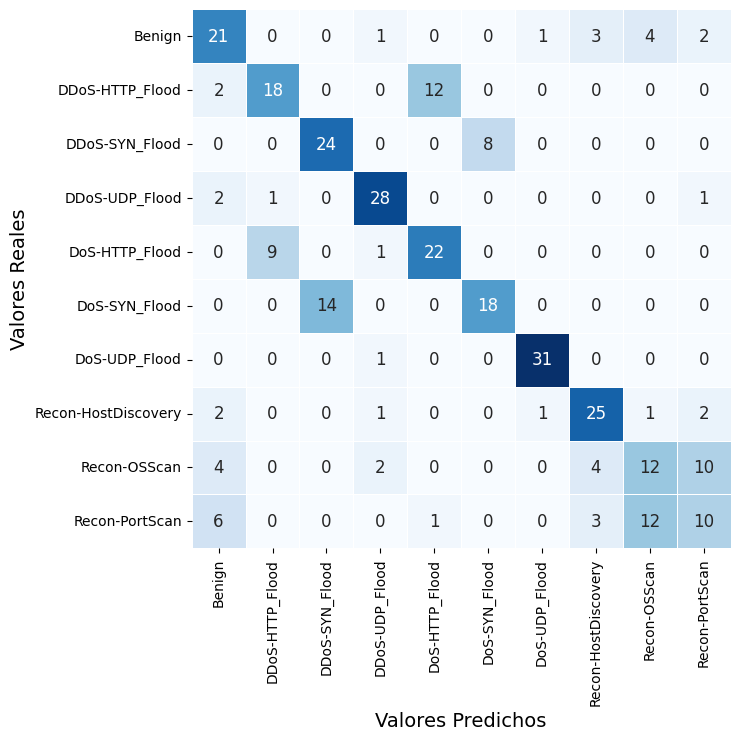

In [21]:
from sklearn import metrics
y_pred = SVM.predict(matrix_test)
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

# Plot
sns.heatmap(
    normalized_matrix, 
    annot=True, 
    fmt='0.0f', 
    linewidth=0.5,
    annot_kws={"size": 12}, 
    xticklabels=class_names,
    yticklabels=class_names, 
    square=True, 
    cmap='Blues', 
    cbar=False
)

fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.ylabel('Valores Reales', fontsize=14)
plt.xlabel('Valores Predichos', fontsize=14)

# Guardar como PDF (¡hazlo antes del plt.show!)
plt.savefig('CM_QSVM.pdf', format='pdf', bbox_inches='tight')

plt.show()


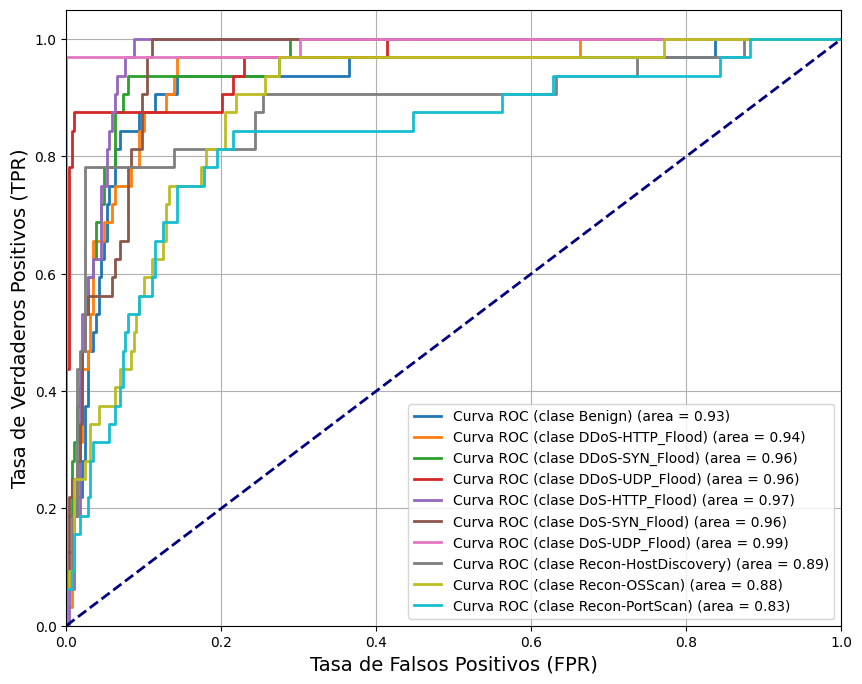

In [22]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = SVM.decision_function(matrix_test)

# Binarizar las etiquetas
from sklearn.preprocessing import label_binarize
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], lw=2,
             label=f'Curva ROC (clase {class_label}) (area = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC_SQVM.pdf', format='pdf', bbox_inches='tight')
plt.show()
